# はじめに


この notebook では継承タブの複数枚画像を 1 枚に結合(レシート因子作成くんのデフォルト結合)する方法について説明していきます  
 **※随所にマジックナンバーが入っていますが、なぜ入れたのか覚えてない箇所が多数あります…**


# 前準備


## パッケージのインストール


In [ ]:
%pip install numpy
%pip install matplotlib
%pip install opencv-python


## パッケージの読み込み


In [2]:
import collections
import matplotlib.pyplot as plt
import numpy as np
import cv2 as cv


## 2 値化した色の定数


In [3]:
BLACK = 0
WHITE = 255


## 画像表示用関数の定義


In [4]:
def imgshow(src):
    # 複数枚
    if type(src) is list:
        fig = plt.figure(figsize=(8 * len(src), 16))
        for i, img in enumerate(src, 1):
            ax = fig.add_subplot(1, len(src), i)
            # グレースケール
            if img.ndim == 2:
                ax.imshow(img, cmap='gray', vmin=0, vmax=255)
            # BGR
            elif img.shape[2] == 3:
                ax.imshow(cv.cvtColor(img, cv.COLOR_BGR2RGB))
            # BGRA
            elif img.shape[2] == 4:
                ax.imshow(cv.cvtColor(img, cv.COLOR_BGRA2RGBA))
    # 1枚
    else:
        plt.figure(figsize=(8, 16))
        if src.ndim == 2:
            plt.imshow(src, cmap='gray', vmin=0, vmax=255)
        elif src.shape[2] == 3:
            plt.imshow(cv.cvtColor(src, cv.COLOR_BGR2RGB))
        elif src.shape[2] == 4:
            plt.imshow(cv.cvtColor(src, cv.COLOR_BGRA2RGBA))

    plt.show()


# 全体の流れ

1. 結合対象画像読み込み
2. 左右余白座標を検出
3. 結合用最下段座標を検出
4. スキル 1 行分テンプレートマッチして結合座標を決定
5. 結合処理  
   (画像枚数分 4~5 を繰り返す)

図にすると以下のイメージです  
<img src="description_1.png" width="600">


## 結合対象画像の読み込み


今回は以下の 3 枚を使い説明していきます  
読み込みは

```c
cv.imread('画像のPath', 読み込み形式)
```

で行います  
読み込み形式は cv.IMREAD_COLOR(BGR)を指定します


1枚目 : 563px x 1000px
2枚目 : 563px x 1000px
3枚目 : 563px x 1000px


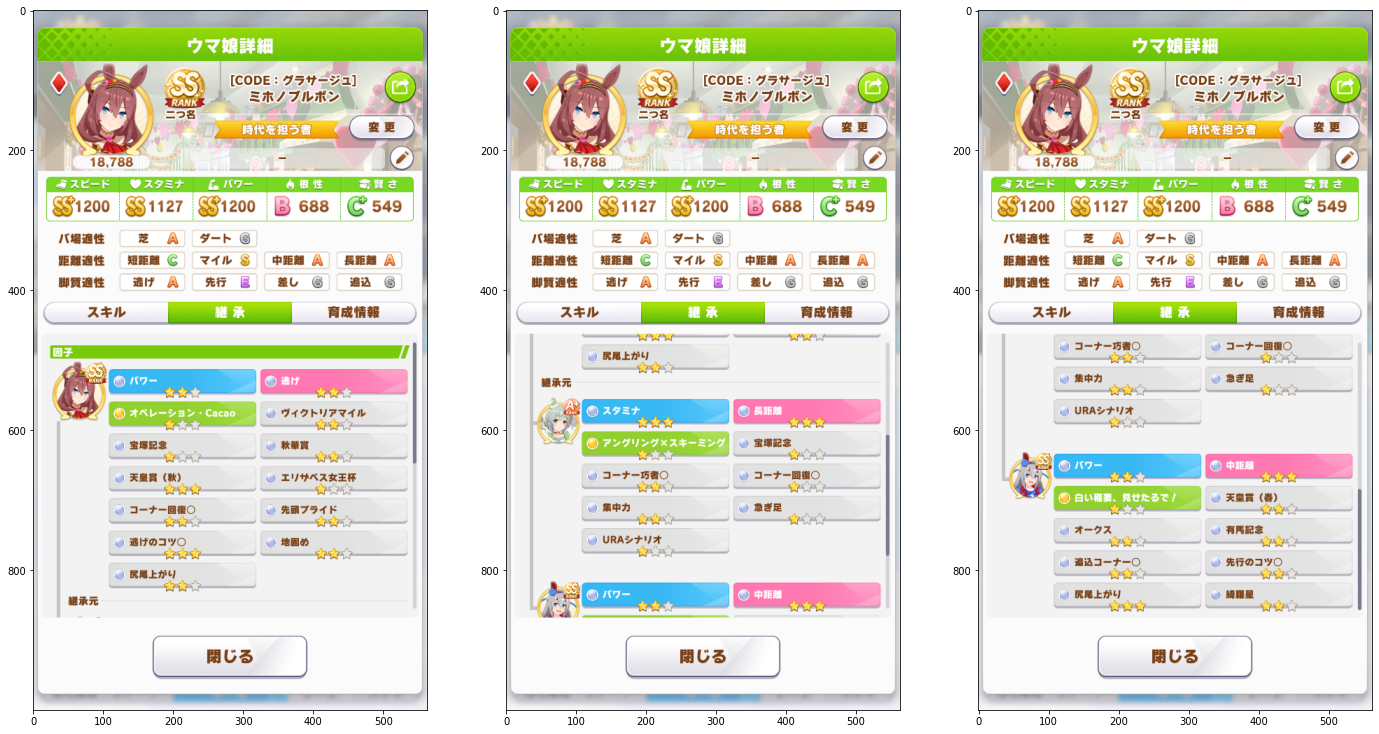

In [5]:
# 結合対象画像をlistへ格納
images = []

for i in np.arange(3):
    img = cv.imread(f'default_{i + 1}.png', cv.IMREAD_COLOR)
    print(f'{i + 1}枚目 : {img.shape[1]}px x {img.shape[0]}px')
    if i > 0:
        # 2枚目以降は解像度違ったらエラー
        if (images[i - 1].shape[0] != img.shape[0]) | (images[i - 1].shape[1] != img.shape[1]):
            raise Exception('異なる解像度の画像が入力されています')

    images.append(img)
imgshow(images)


## 左右余白座標を検出


### 左右余白座標を検出する目的

2 つあります

1. テンプレートマッチの範囲から、左右余白を除外する為
2. オプション機能「左右を切り落とす」を利用する場合の切り落とし座標として使用する為


### 検出方法

1. 元画像を HSV 色空間に変換する
2. HSV 色空間に変換した画像を 2 値化(白黒化)する
3. 左端から黒になる Pixel を探す

言葉では想像し辛いと思うので、順番に説明していきます


#### 元画像を HSV 色空間に変換する

BGR 色空間から HSV 色空間へ変換します  
HSV 色空間についてはここでは説明しませんので調べてみて下さい


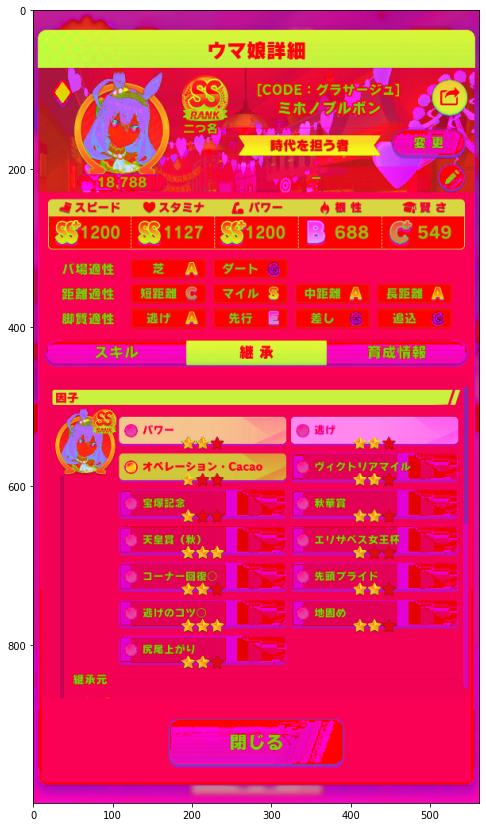

In [6]:
img = images[0]
hsv = cv.cvtColor(img, cv.COLOR_BGR2HSV_FULL)
imgshow(hsv)


#### HSV 色空間に変換した画像を 2 値化(白黒化)する

inRange 関数は画像から特定の色を抽出したい場合に使用します  
今回は左端の境界が際立つような値(min,max)を指定して変換を行います

なお、どの値(min,max)が適切なのかは、試行錯誤して決めました


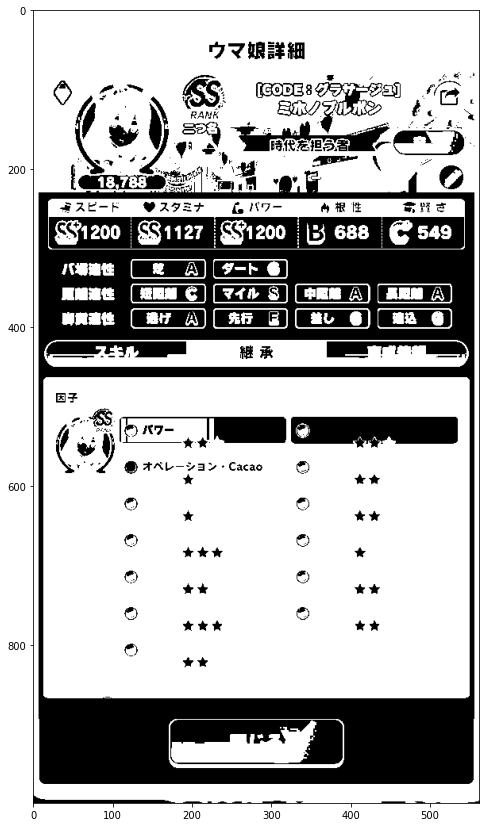

In [7]:
min = (0, 0, 0)
max = (255, 255, 245)
inrange = cv.inRange(hsv, min, max)
imgshow(inrange)


#### 左端から黒になる Pixel を探す

2 値化された画像の、左端から何 Pixel 目に黒が出現するかを見ていきます  
「レシート因子作成くん」は、全体の高さ 50%～ 85%(↓ 画像の緑枠)の範囲を、  
上から順に見ていき一番頻出頻度が多かった座標を左余白座標としています  
なお、右の余白は左の余白と長さが一緒なので、左側が求まると右側は計算で求めることができます


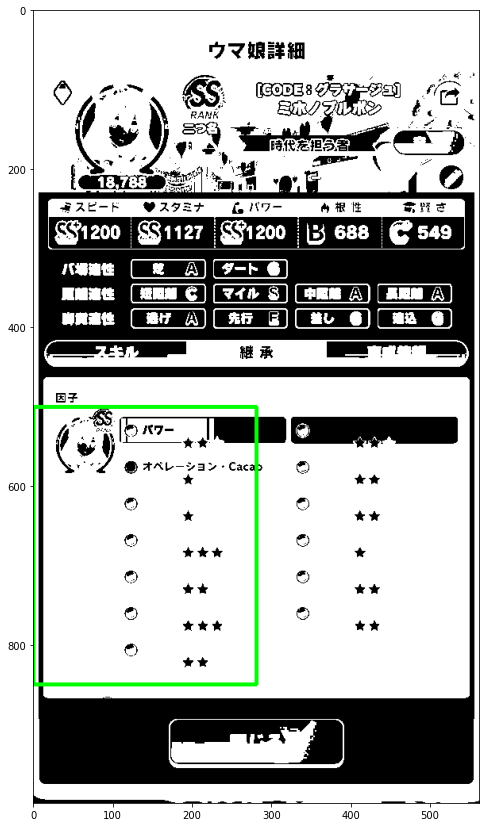

In [8]:
# 目安として探索する範囲緑枠で表示
tmp_img = cv.cvtColor(inrange, cv.COLOR_GRAY2BGR)
cv.rectangle(tmp_img, pt1=(0, int(tmp_img.shape[0] * 0.5)),
             pt2=(int(tmp_img.shape[1] * 0.5), int(tmp_img.shape[0] * 0.85)),
             color=(0, 255, 0), thickness=3)
imgshow(tmp_img)


#### 検出処理


検出されたX座標と回数
[(7, 350)]

余白座標: 左:7 右:556

赤い点が検出箇所


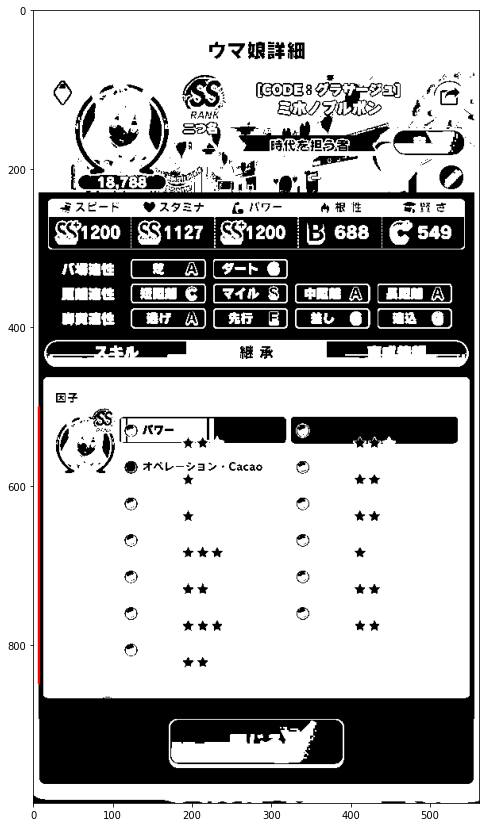

In [9]:
# 左端の座標を保存するリスト
positions = []

# 画像の幅と高さ
h, w = inrange.shape

# 元画像(検証用)
tmp_img = cv.cvtColor(inrange, cv.COLOR_GRAY2BGR)

# 上から順に見ていく
for y in np.arange(int(h * 0.5), int(h * 0.85)):
    findWhite = False
    # 左(一番左は飛ばす)から順に見ていく
    for x in np.arange(1, int(w * 0.5)):
        # Windows版ではWindow枠があると、即黒を検知してしまうので、
        # 「一度白を見つけた後に、黒を見つけたら」という条件にする
        if (not findWhite) & (inrange[y, x] == WHITE):
            findWhite = True
        elif (findWhite) & (inrange[y, x] == BLACK):
            positions.append(x)
            # 元画像(検証用)に検出点を赤で色付け
            cv.line(tmp_img, pt1=(x, y), pt2=(x, y),
                    color=(0, 0, 255), thickness=2)
            break

c = collections.Counter(positions)
print('検出されたX座標と回数')
print(c.most_common(5))

# リストから一番多い出現回数の値(座標)を取得
margin_left = c.most_common(1)[0][0]
# 右端は左端と同じ距離なので、全体の幅から左端座標を引けば求まる
margin_right = w - margin_left
print(f'\n余白座標: 左:{margin_left} 右:{margin_right}')

print('\n赤い点が検出箇所')
imgshow(tmp_img)


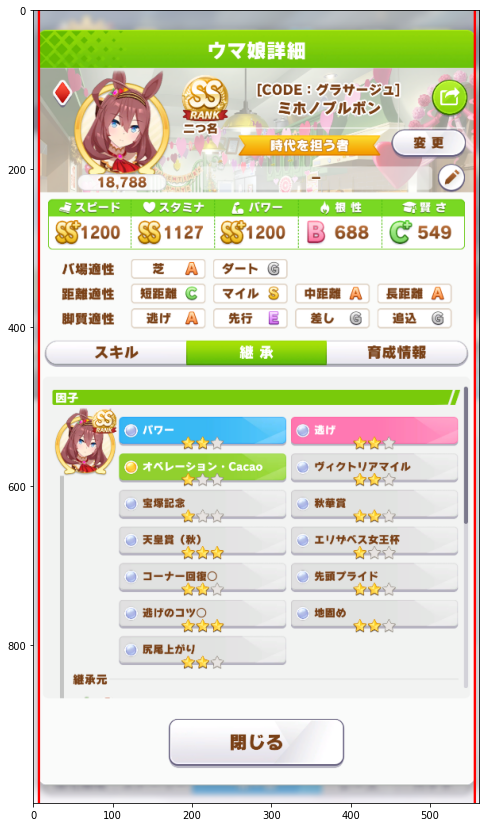

In [10]:
# 求めた座標が適切か元画像に線を引いて確かめてみる
tmp_img = images[0].copy()
cv.line(tmp_img, pt1=(margin_left, 0), pt2=(margin_left,
        tmp_img.shape[0]), color=(0, 0, 255), thickness=2)
cv.line(tmp_img, pt1=(margin_right, 0), pt2=(margin_right,
        tmp_img.shape[0]), color=(0, 0, 255), thickness=2)
imgshow(tmp_img)


## 結合用最下段座標を検出


### 検出方法

1. 元画像を HSV 色空間に変換する
2. HSV 色空間に変換した画像を 2 値化(白黒化)する
3. 上から 1 行ずつ、白が含まれていない行を探す

1,2 は左右余白座標検出処理と同じ画像を使用します(2 値化するパラメータも同じです)


#### 上から 1 行ずつ、白が含まれていない行を探す

「レシート因子作成くん」は、全体の高さ 71%～ 95%(↓ 画像の緑枠)の範囲を  
上から順に見ていき、白が含まれていない行(Y 座標)を探しています  
なお X の範囲は、先程検出した余白座標を除いています


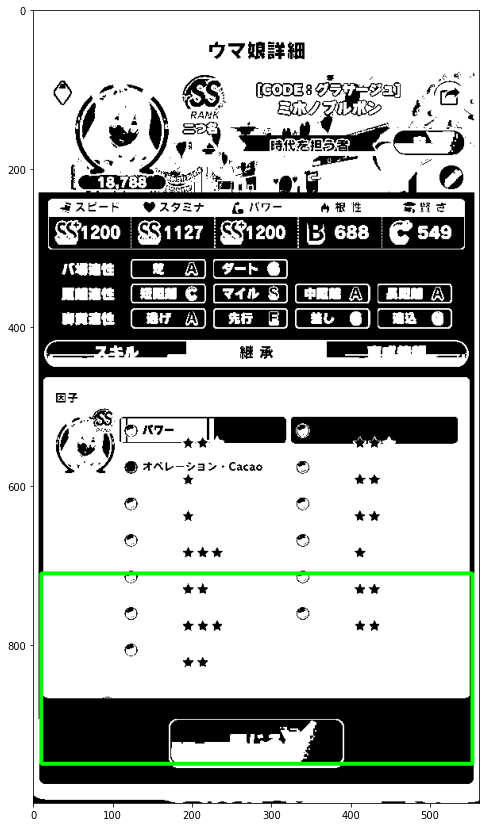

In [11]:
# 目安として探索する範囲緑枠で表示
tmp_img = cv.cvtColor(inrange, cv.COLOR_GRAY2BGR)
cv.rectangle(tmp_img, pt1=(margin_left + 3, int(tmp_img.shape[0] * 0.71)),
             pt2=(w - margin_left - 3, int(tmp_img.shape[0] * 0.95)),
             color=(0, 255, 0), thickness=3)
imgshow(tmp_img)


#### 検出処理


In [12]:
for y in np.arange(int(h * 0.71), int(h * 0.95)):
    if WHITE not in inrange[y, margin_left + 3:w - margin_left - 3]:
        margin_bottom = y - 1
        break
print(f'結合用最下段座標:{margin_bottom}')


結合用最下段座標:867


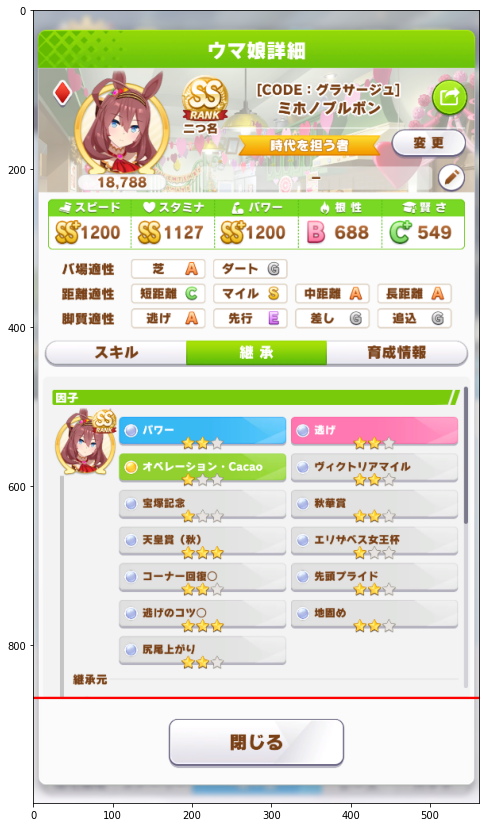

In [13]:
# 求めた座標が適切か元画像に線を引いて確かめてみる
tmp_img = images[0].copy()
cv.line(tmp_img, pt1=(0, margin_bottom), pt2=(
    tmp_img.shape[1], margin_bottom), color=(0, 0, 255), thickness=2)
imgshow(tmp_img)


## スキル 1 行分テンプレートマッチして結合座標を決定


結合元画像の最下段スキル 1 行分を切り取り、次画像とテンプレートマッチをして結合箇所を決定します  
テンプレートマッチについてはここでは説明しませんので調べてみて下さい


## スキル 1 行分切り取り


前述の「左右余白座標」と「結合用最下段座標」を利用して切り取ります  
なお、スキル 1 行分の高さは画像全体の高さの 4%程度です


### おさらい(「左右余白座標」と「結合用最下段座標」を赤枠で囲う)


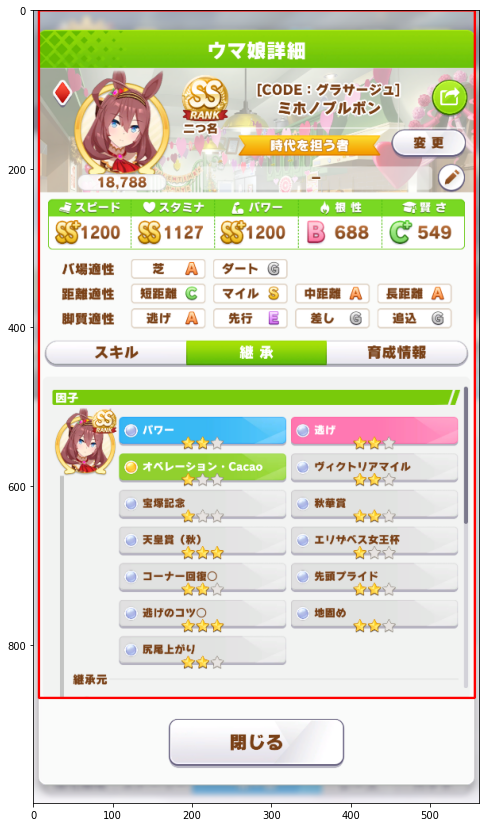

In [14]:
tmp_img = images[0].copy()
cv.rectangle(tmp_img, pt1=(margin_left, 0), pt2=(
    margin_right, margin_bottom), color=(0, 0, 255), thickness=2)
imgshow(tmp_img)


### スキル 1 行分の高さで囲ってみる


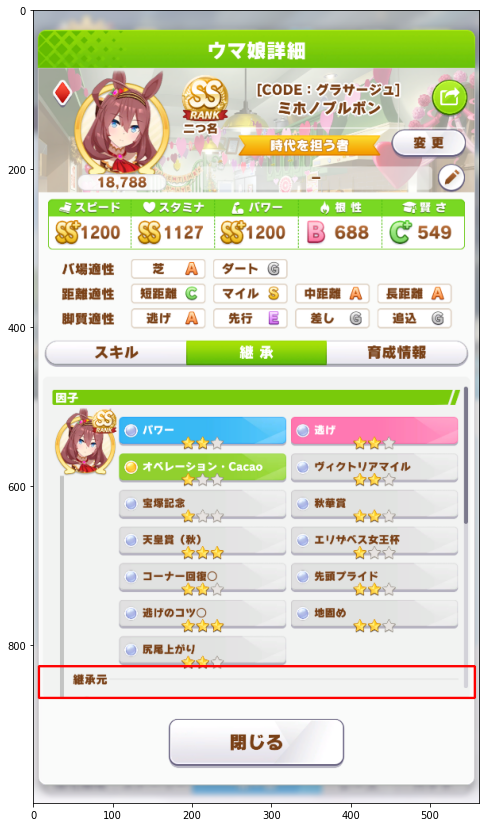

In [15]:
tmp_img = images[0].copy()

# スキル1行分の高さ
skill_height = int(tmp_img.shape[0] * 0.04)
cv.rectangle(tmp_img, pt1=(margin_left, margin_bottom - skill_height),
             pt2=(margin_right, margin_bottom), color=(0, 0, 255), thickness=2)
imgshow(tmp_img)


### スクロールバーが含まれてしまっている(テンプレートマッチ結果に影響してしまう)ので枠を縮める


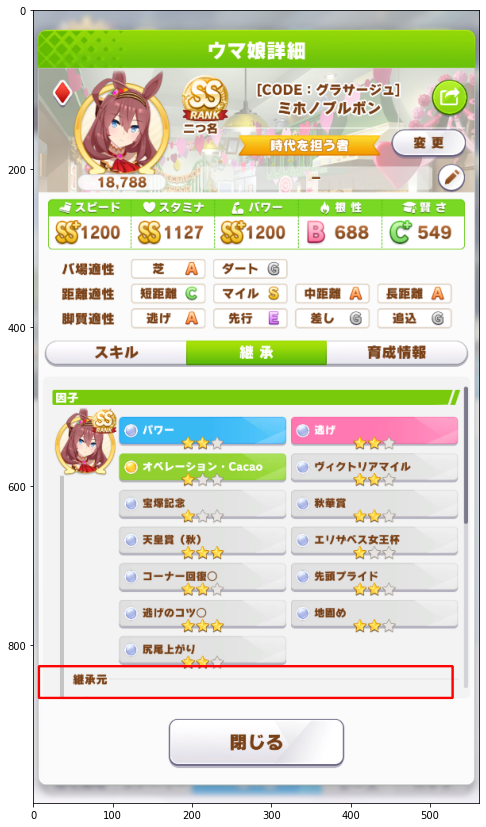

In [16]:
tmp_img = images[0].copy()

# ↑の赤枠の幅を95%程度にすると丁度良くなる
skill_right = margin_left + int((margin_right - margin_left) * 0.95)
cv.rectangle(tmp_img, pt1=(margin_left, margin_bottom - skill_height),
             pt2=(skill_right, margin_bottom), color=(0, 0, 255), thickness=2)
imgshow(tmp_img)


### スキル 1 行分切り抜き


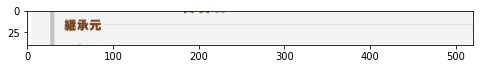

In [17]:
img = images[0].copy()
skill_img = img[margin_bottom -
                skill_height: margin_bottom, margin_left: skill_right]
# サンプルの画像が悪くてごめんなさい…
imgshow(skill_img)


## テンプレートマッチ


グレースケール画像


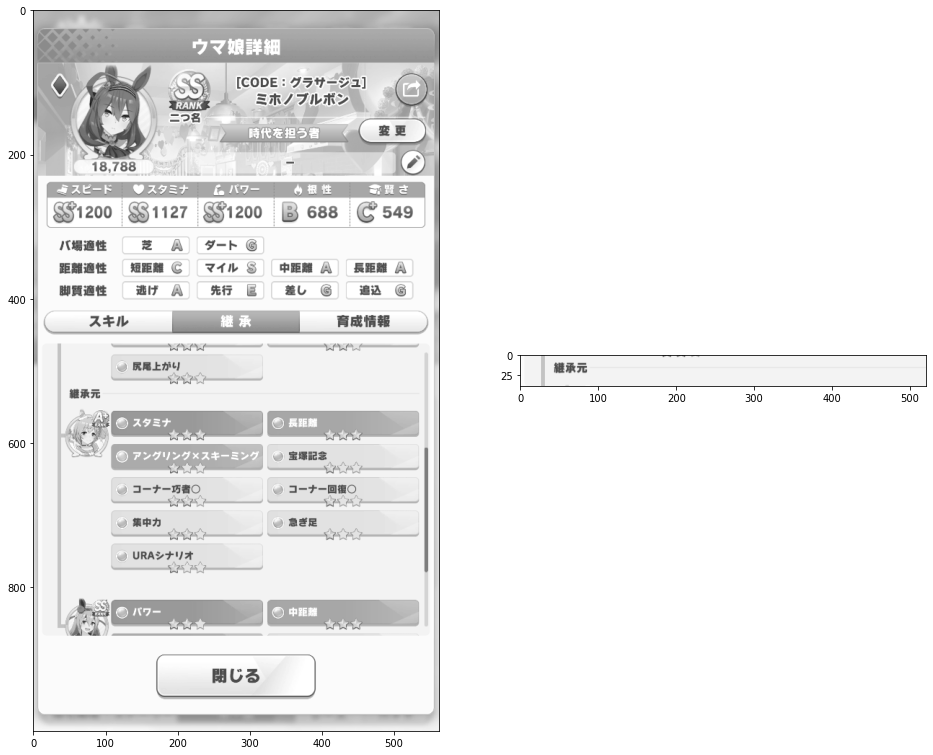


テンプレートマッチ結果
-0.3212513029575348 0.9999441504478455 (5, 1) (7, 515)

類似度が最も高い場所


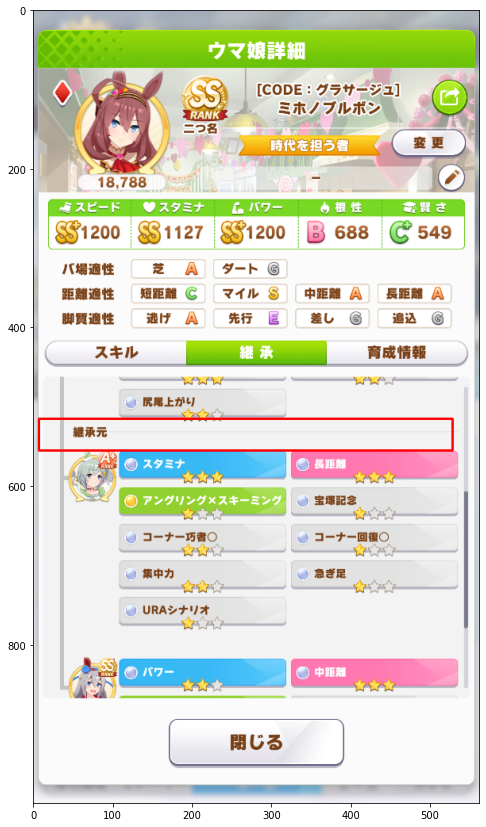


結合用に切り抜き


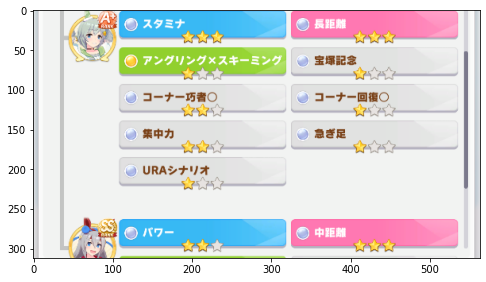

In [18]:
# 次画像
img = images[1]

# グレースケール化
img_gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
skill_gray = cv.cvtColor(skill_img, cv.COLOR_BGR2GRAY)

print('グレースケール画像')
imgshow([img_gray, skill_gray])

res = cv.matchTemplate(img_gray, skill_gray, cv.TM_CCOEFF_NORMED)
min_val, max_val, min_loc, max_loc = cv.minMaxLoc(res)
print('\nテンプレートマッチ結果')
print(min_val, max_val, min_loc, max_loc)

# 類似度が最も高い場所を赤枠で囲ってみる
tmp_img = img.copy()
cv.rectangle(tmp_img, pt1=(max_loc[0], max_loc[1]), pt2=(
    max_loc[0] + skill_img.shape[1], max_loc[1] + skill_img.shape[0]), color=(0, 0, 255), thickness=2)
print('\n類似度が最も高い場所')
imgshow(tmp_img)

# 結合用に切り抜いてみる
clip_img = img[max_loc[1] + skill_gray.shape[0]: margin_bottom, :]
print('\n結合用に切り抜き')
imgshow(clip_img)


## 結合処理


### 1 枚目と 2 枚目は作成済みなのでリストに退避


In [19]:
clip_imgs = []
# 1枚目
clip_imgs.append(images[0][: margin_bottom, :])
# 2枚目
clip_imgs.append(clip_img)


### 2 枚目と 3 枚目の結合箇所を検出


グレースケール画像


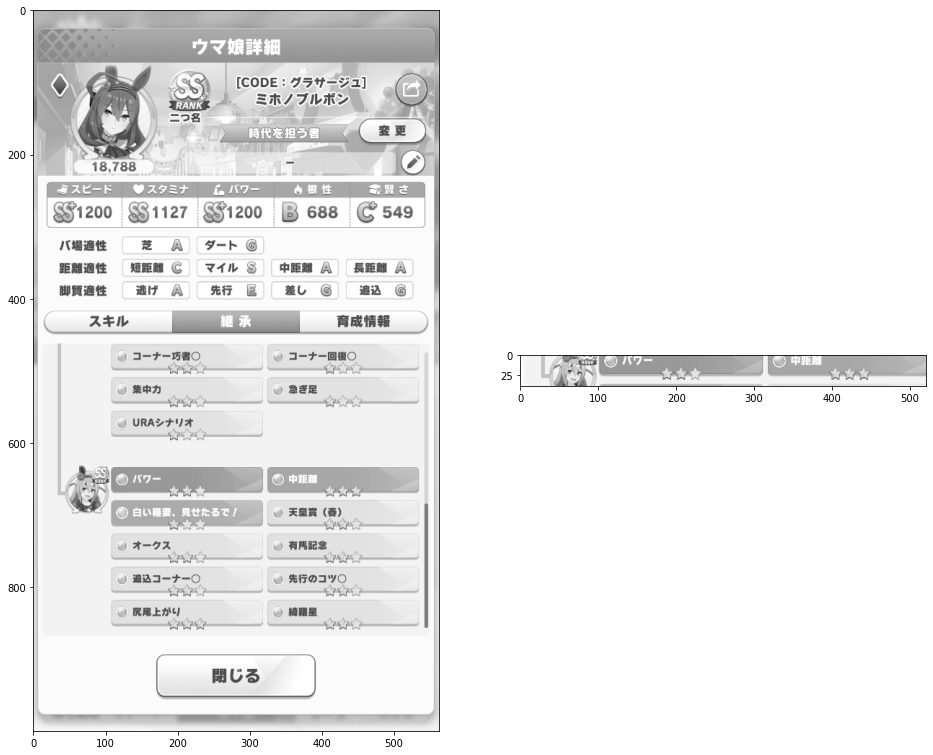


テンプレートマッチ結果
-0.5090722441673279 0.9547315239906311 (2, 606) (7, 643)

類似度が最も高い場所


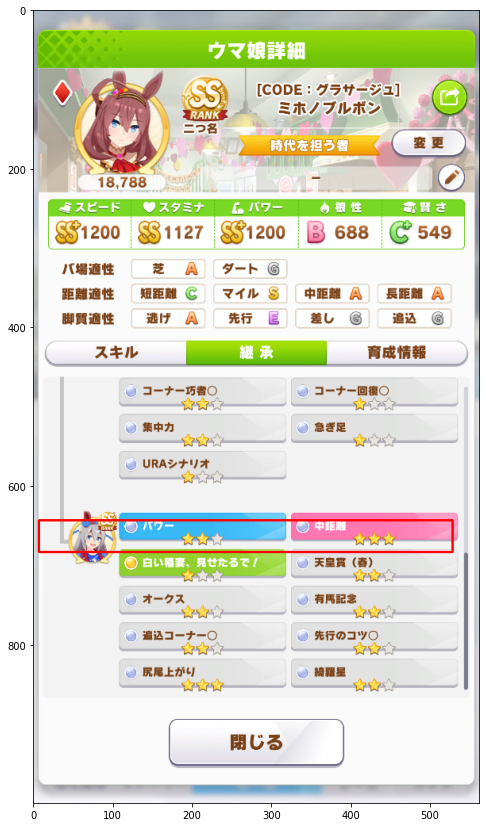


結合用に切り抜き


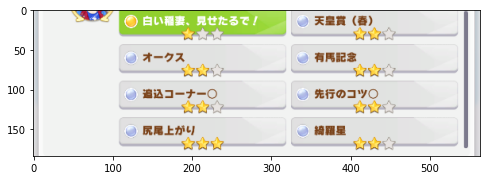

In [20]:
# 2枚目のスキル画像
skill_img = images[1][margin_bottom -
                      skill_height: margin_bottom, margin_left: skill_right]

# 3枚目
img = images[2]

# グレースケール化
img_gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
skill_gray = cv.cvtColor(skill_img, cv.COLOR_BGR2GRAY)

print('グレースケール画像')
imgshow([img_gray, skill_gray])

res = cv.matchTemplate(img_gray, skill_gray, cv.TM_CCOEFF_NORMED)
min_val, max_val, min_loc, max_loc = cv.minMaxLoc(res)
print('\nテンプレートマッチ結果')
print(min_val, max_val, min_loc, max_loc)

# 類似度が最も高い場所を赤枠で囲ってみる
tmp_img = img.copy()
cv.rectangle(tmp_img, pt1=(max_loc[0], max_loc[1]), pt2=(
    max_loc[0] + skill_img.shape[1], max_loc[1] + skill_img.shape[0]), color=(0, 0, 255), thickness=2)
print('\n類似度が最も高い場所')
imgshow(tmp_img)

# 結合用に切り抜いてみる
clip_img = img[max_loc[1] + skill_gray.shape[0]: margin_bottom, :]
print('\n結合用に切り抜き')
imgshow(clip_img)


### 3 枚目の切り抜き画像をリストに追加


In [21]:
clip_imgs.append(clip_img)
len(clip_imgs)


3

### 結合処理(単純縦結合)


結合結果


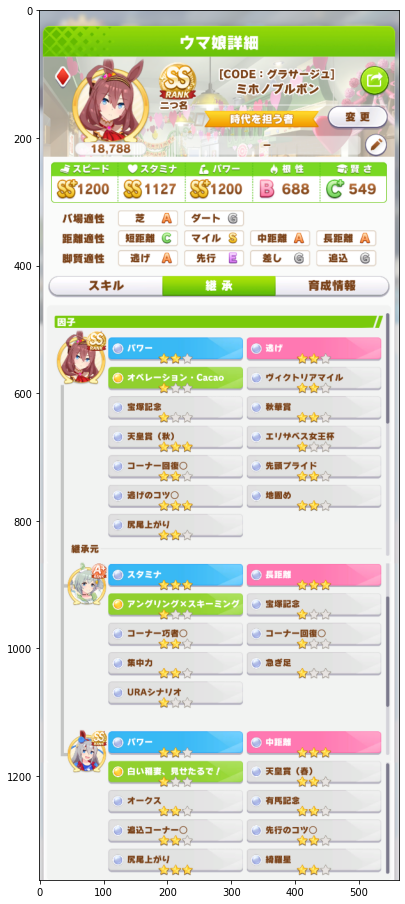

In [22]:
width = clip_imgs[0].shape[1]
height = sum(m.shape[0] for m in clip_imgs)
output_img = np.zeros((height, width, 3), dtype=np.uint8)
y = 0
for clip_img in clip_imgs:
    output_img[y: y + clip_img.shape[0], 0: clip_img.shape[1]] = clip_img
    y += clip_img.shape[0]
print('結合結果')
imgshow(output_img)


# 余談:オプション機能「左右を切り落とす」

結合結果から左右余白(margin_left, margin_right)を切り落とすだけです


7 556


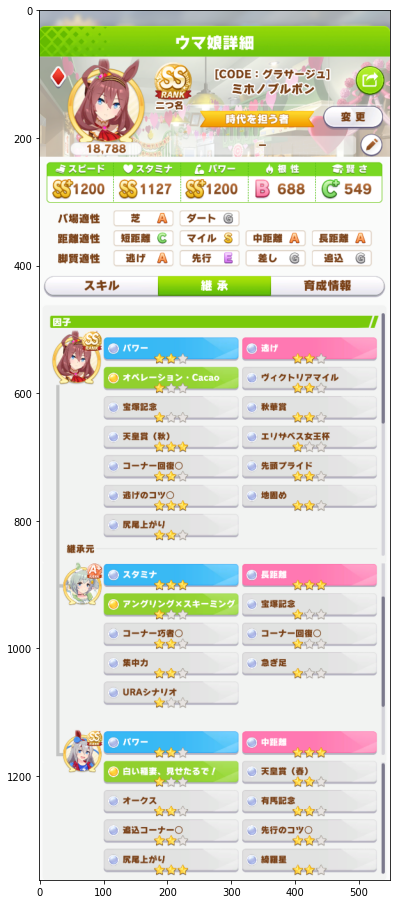

In [23]:
print(margin_left, margin_right)

clip_img = output_img[:, margin_left: margin_right]
imgshow(clip_img)
